In [ ]:
cd /content/drive/MyDrive/Kaggle

/content/drive/MyDrive/Kaggle


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Kaggle"

In [ ]:
!kaggle datasets download -d tawsifurrahman/tuberculosis-tb-chest-xray-dataset

tuberculosis-tb-chest-xray-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision
import torchvision.models as models
from torchvision import datasets, transforms
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

In [ ]:
!unzip *.zip  && rm *.zip

Archive:  tuberculosis-tb-chest-xray-dataset.zip
  inflating: TB_Chest_Radiography_Database/Normal.metadata.xlsx  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-10.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-100.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1000.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1001.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1002.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1003.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1004.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1005.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1006.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1007.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1008.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1009.png  
  infla

In [ ]:
train_transforms = transforms.Compose([transforms.Resize((120, 120)),
                                       transforms.ColorJitter(0.05),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.RandomRotation(20),
                                       transforms.ToTensor(), 
                                       transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                                     ])

train_set = datasets.ImageFolder(r"/content/drive/MyDrive/Kaggle/TB_Chest_Radiography_Database", transform = train_transforms)

In [ ]:
test_size = 0.2
num_train = len(train_set)
indices = list(range(num_train))
np.random.shuffle(indices)

test_split = int(np.floor((test_size)*num_train))
train_index, test_index = indices[test_split - 1 :], indices[: test_split - 1]

train_sampler = SubsetRandomSampler(train_index)
test_sampler = SubsetRandomSampler(test_index)

train_loader = DataLoader(train_set, sampler=train_sampler, batch_size=104)
test_loader = DataLoader(train_set, sampler=test_sampler, batch_size=58)

print("Images in Test set: {}\nImages in Train set: {}".format(len(test_index), len(train_index)))

Images in Test set: 839
Images in Train set: 3361


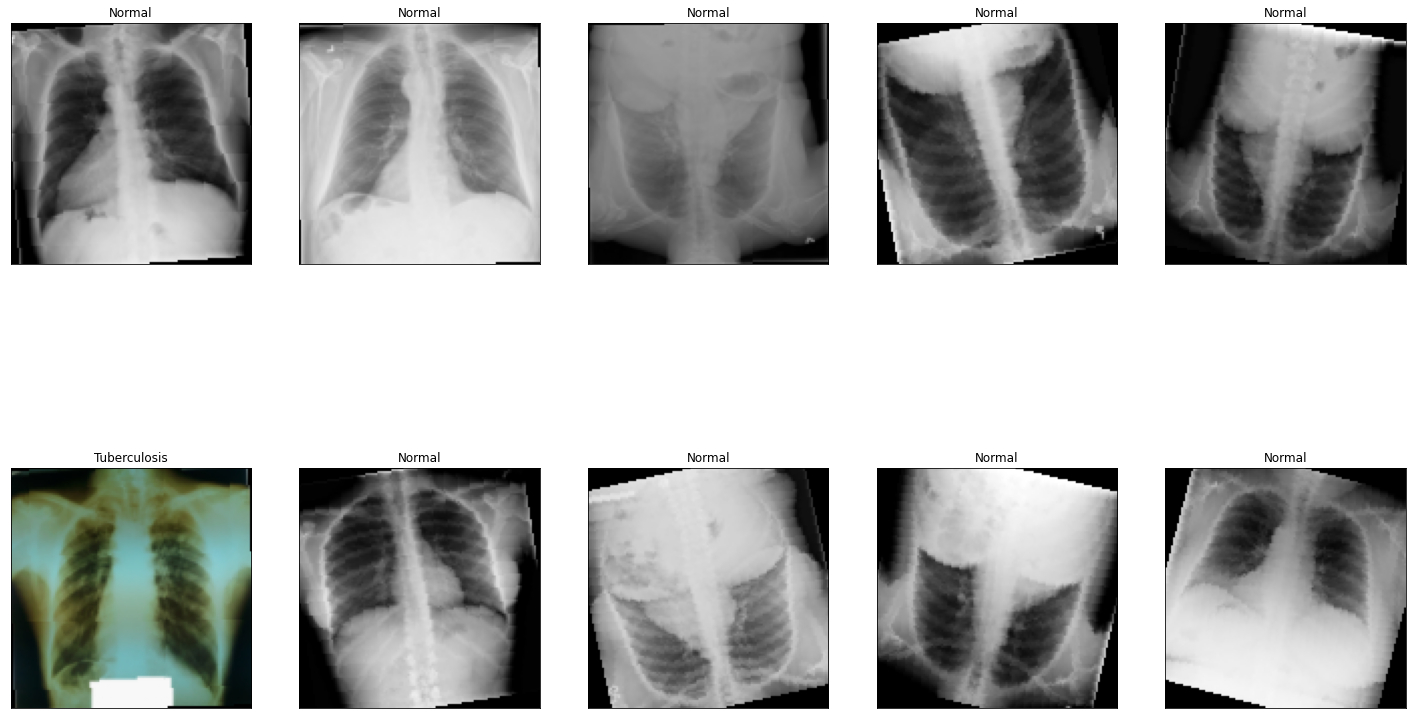

In [ ]:
classes=['Normal','Tuberculosis']
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
images, labels = next(iter(train_loader))

fig = plt.figure(figsize=(25, 15))

for i in range(10):
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[], title=classes[labels[i]])
    imshow(images[i])
plt.show()

In [ ]:
model = models.resnet34(pretrained = True)
num_features_last = model.fc.in_features
model.fc = nn.Linear(num_features_last, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
error = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Epoch: 1, Loss: 0.0315
Epoch: 2, Loss: 0.0442
Epoch: 3, Loss: 0.0294
Epoch: 4, Loss: 0.0205
Epoch: 5, Loss: 0.0219
Epoch: 6, Loss: 0.0271
Epoch: 7, Loss: 0.0320
Epoch: 8, Loss: 0.0190
Epoch: 9, Loss: 0.0269
Epoch: 10, Loss: 0.0308


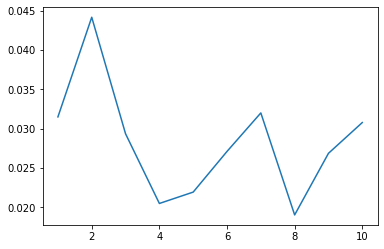

In [ ]:
num_epochs = 10
batch_size = 100 

def plot_loss(epoch, loss):
  plt.plot(epoch, loss)

loss_val = []

for epoch in range(num_epochs):
    train_loss = 0.
    model.train()    # explictily stating the training
    
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        train = images.view(-1, 3, 120, 120)
        outputs = model(train)
        
        optimizer.zero_grad()
        loss = error(outputs, labels)
        loss.backward()    #back-propagation
        optimizer.step()
        
        train_loss += loss.item() * batch_size


    loss_val.append(train_loss / len(train_loader.dataset)) 
    print("Epoch: {}, Loss: {:.4f}".format(epoch + 1, train_loss / len(train_loader.dataset)))

plot_loss(np.linspace(1, num_epochs, num_epochs).astype(int), loss_val)

In [ ]:
correct = 0
total = 0
class_total = [0 for _ in range(2)]
class_correct = [0 for _ in range(2)]
batch_size = 20
# Lists used in Confusion Matrix
actual = []
predict = []

model.eval()    # explicitly stating the testing 
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to (device)
        
        actual.append(labels.data.tolist())
        test = images.view(-1, 3, 120, 120)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        predict.append(predicted.data.tolist())
        total += len(labels)
        correct += (predicted == labels).sum().item()
        # Calculating classwise accuracy
        c = (predicted == labels).squeeze()
        for i in range(batch_size):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
        
print("Accuracy on the Test set: {:.2f}%".format(correct * 100 / total))
print()
for i in range(2):
    print("Accuracy of {} :  {:.2f}%   [{} / {}]".format(classes[i], class_correct[i] * 100 / class_total[i], 
                                           class_correct[i], class_total[i]))

Accuracy on the Test set: 97.14%

Accuracy of Normal :  94.65%   [230 / 243]
Accuracy of Tuberculosis :  94.74%   [54 / 57]


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import itertools

#flatten out 2D list into 1D
actual = list(itertools.chain.from_iterable(actual))
predict = list(itertools.chain.from_iterable(predict))
results = confusion_matrix(actual, predict)
print("Accuracy Score: ")
print("{:.4f}".format(accuracy_score(actual, predict)))
print()
print("Report: ")
print(classification_report(actual, predict))
print()
print("Confusion Matrix: ")
print(pd.DataFrame(results, columns=["Predicted No", "Predicted Yes"], index=["Actual No", "Actual Yes"]))

Accuracy Score: 
0.9714

Report: 
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       697
           1       0.88      0.96      0.92       142

    accuracy                           0.97       839
   macro avg       0.94      0.97      0.95       839
weighted avg       0.97      0.97      0.97       839


Confusion Matrix: 
            Predicted No  Predicted Yes
Actual No            678             19
Actual Yes             5            137
